In [1]:
import torch
from torch import Tensor, LongTensor, tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss, L1Loss, ReLU, Module, NLLLoss, Sigmoid
from torch.optim import LBFGS
import torch.optim as optim
from torch import cat, no_grad, manual_seed
import torch.nn.functional as F

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
import time

from qiskit.circuit import Parameter
from qiskit import QuantumCircuit
from qiskit_algorithms.utils import algorithm_globals
from qiskit.quantum_info import SparsePauliOp

from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap, RealAmplitudes
from qiskit_machine_learning.circuit.library import QNNCircuit
from qiskit_machine_learning.neural_networks import EstimatorQNN, SamplerQNN
from qiskit_machine_learning.connectors import TorchConnector 

from qiskit_aer import AerSimulator
from qiskit.providers.fake_provider import FakeVigo
from qiskit.primitives import BackendSampler, BackendEstimator

## Importing the dataset

In [2]:
file_path = "../Fraud-Detection-with-QML/dataset/dataset.csv"

try:
    df = pd.read_csv(file_path)
    print("Dataset imported successfully.")
except FileNotFoundError:
    print("File not found. Please check the file path.")
    exit()


Dataset imported successfully.


## Feature cleaning

In [3]:
df.drop(columns=['step'], inplace=True)
df.drop(columns=['zipcodeOri'], inplace=True)
df.drop(columns=['zipMerchant'], inplace=True)
df.drop(columns=['customer'], inplace=True)
df.drop(columns=['merchant'], inplace=True)

In [4]:
encoder = LabelEncoder()

encoded_age = encoder.fit_transform(df['age'])
df['age'] = encoded_age
encoded_gender = encoder.fit_transform(df['gender'])  #This could be a binary encoding (or not)
df['gender'] = encoded_gender
encoded_category = encoder.fit_transform(df['category']) #This could be a binary encoding
df['category'] = encoded_category


## Undersampling

Since the dataset is too large and really unbalanced, an undersampling of 100 fraud and 100 non fraud cases is considered at first

In [5]:
X = df.drop('fraud', axis=1)
y = df['fraud']

# undesapling the dataset to have only 100 fraud and 100 non-fraud samples
sampling_strategy = {0: 100, 1: 100}

# Undersample the majority class
undersample = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
X_resampled, y_resampled = undersample.fit_resample(X, y)

In [6]:
print(X_resampled.shape[0])
print(type(X_resampled))

200
<class 'pandas.core.frame.DataFrame'>


# Datasets

In [7]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=0)
print(X_train.shape, X_test.shape)

(140, 4) (60, 4)


In [8]:
#Defining the "Thin" dataset
X_Thin_train = MinMaxScaler().fit_transform(X_train)
X_Thin_test = MinMaxScaler().fit_transform(X_test)

The feature 'category' is categorical, but in the "Thin" dataset is encoded as integers from 0 to 14.

In the following, the dataset "Large" is created with the binary encoding of this feature. This converts the feature into 4 qubits, each representing a bit of the binary value of each category 

In [9]:
# Defining the "Large" dataset

# X_Large_train
cat0 = []
cat1 = []
cat2 = []
cat3 = []

category = list(X_train['category'])
for i in range(X_train.shape[0]):
    # Convert to binary and remove the '0b' prefix
    binstr = bin(category[i])[2:]
    while len(binstr)<4:
        binstr = '0'+binstr
    #creating the classes for the 0th, 1st, 2nd and 3rd bit of the binary encoding 
    cat0.append(binstr[3])
    cat1.append(binstr[2])
    cat2.append(binstr[1])
    cat3.append(binstr[0])

d = {'age': list(X_train['age']), 'gender': list(X_train['gender']),'cat3': cat3, 'cat2': cat2, 'cat1': cat1, 'cat0': cat0, 'amount': list(X_train['amount'])}

X_Large_train = pd.DataFrame(data=d)
X_Large_train = MinMaxScaler().fit_transform(X_Large_train)



#X_Large_test
cat0 = []
cat1 = []
cat2 = []
cat3 = []

category = list(X_test['category'])
for i in range(X_test.shape[0]):
    # Convert to binary and remove the '0b' prefix
    binstr = bin(category[i])[2:]
    while len(binstr)<4:
        binstr = '0'+binstr
    #creating the classes for the 0th, 1st, 2nd and 3rd bit of the binary encoding 
    cat0.append(binstr[3])
    cat1.append(binstr[2])
    cat2.append(binstr[1])
    cat3.append(binstr[0])

d = {'age': list(X_test['age']), 'gender': list(X_test['gender']),'cat3': cat3, 'cat2': cat2, 'cat1': cat1, 'cat0': cat0, 'amount': list(X_test['amount'])}

X_Large_test = pd.DataFrame(data=d)
X_Large_test = MinMaxScaler().fit_transform(X_Large_test)


In [10]:
# Transforming the y dataframes in to ndarrays

# y01 represent the arrays of values between 0 and 1 (used for the sampler and the hybrid)
y01_train = y_train.to_numpy()
y01_test = y_test.to_numpy()

# these y are in the range (-1, 1) and are used for the estimator
y_train = (y01_train * 2) - 1
y_test = (y01_test * 2) - 1

# Feature maps

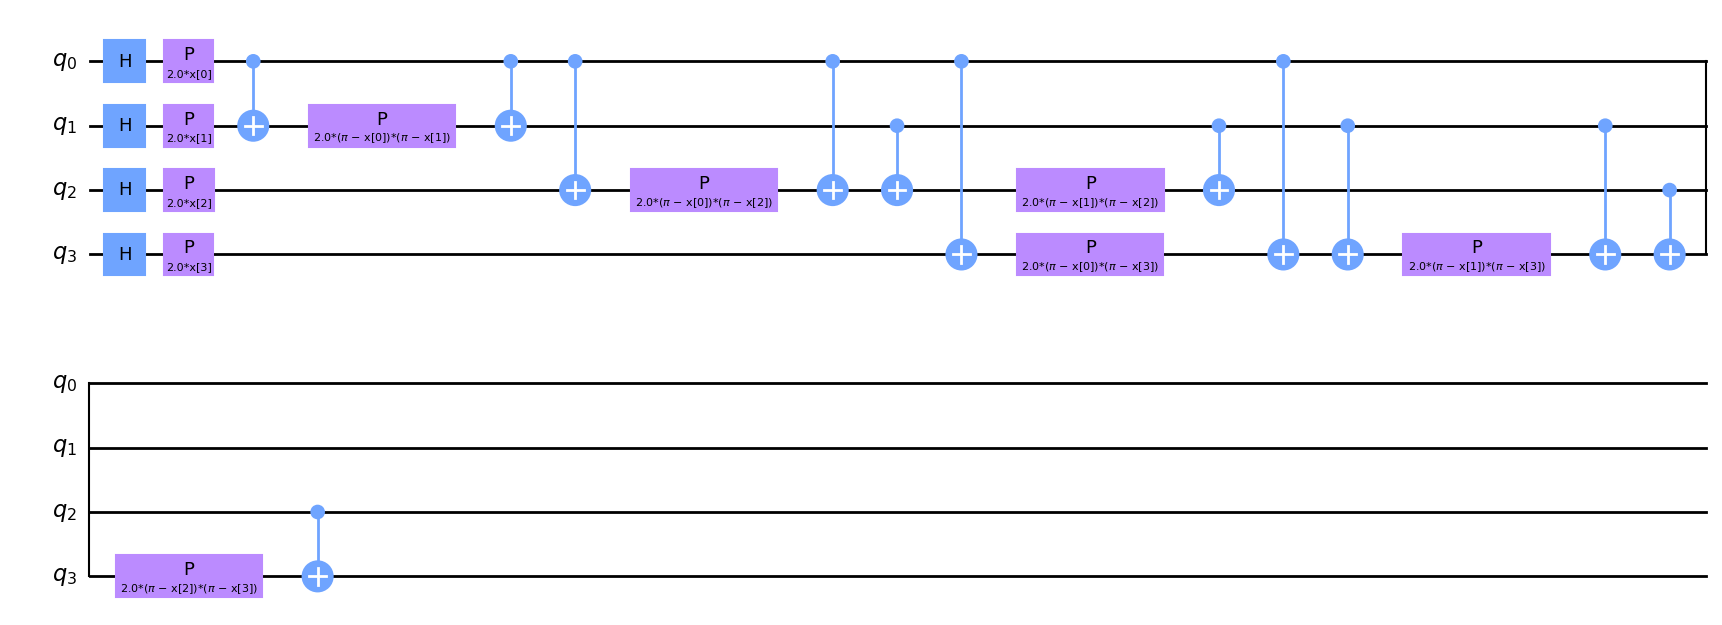

In [11]:
ZZ = ZZFeatureMap(feature_dimension=4, reps=1)   
ZZ.decompose().draw(output='mpl')

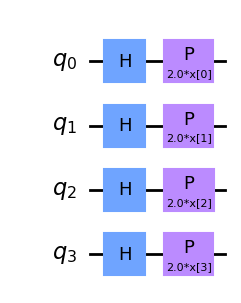

In [12]:
Z = ZFeatureMap(feature_dimension=4, reps=1)
Z.decompose().draw(output='mpl')

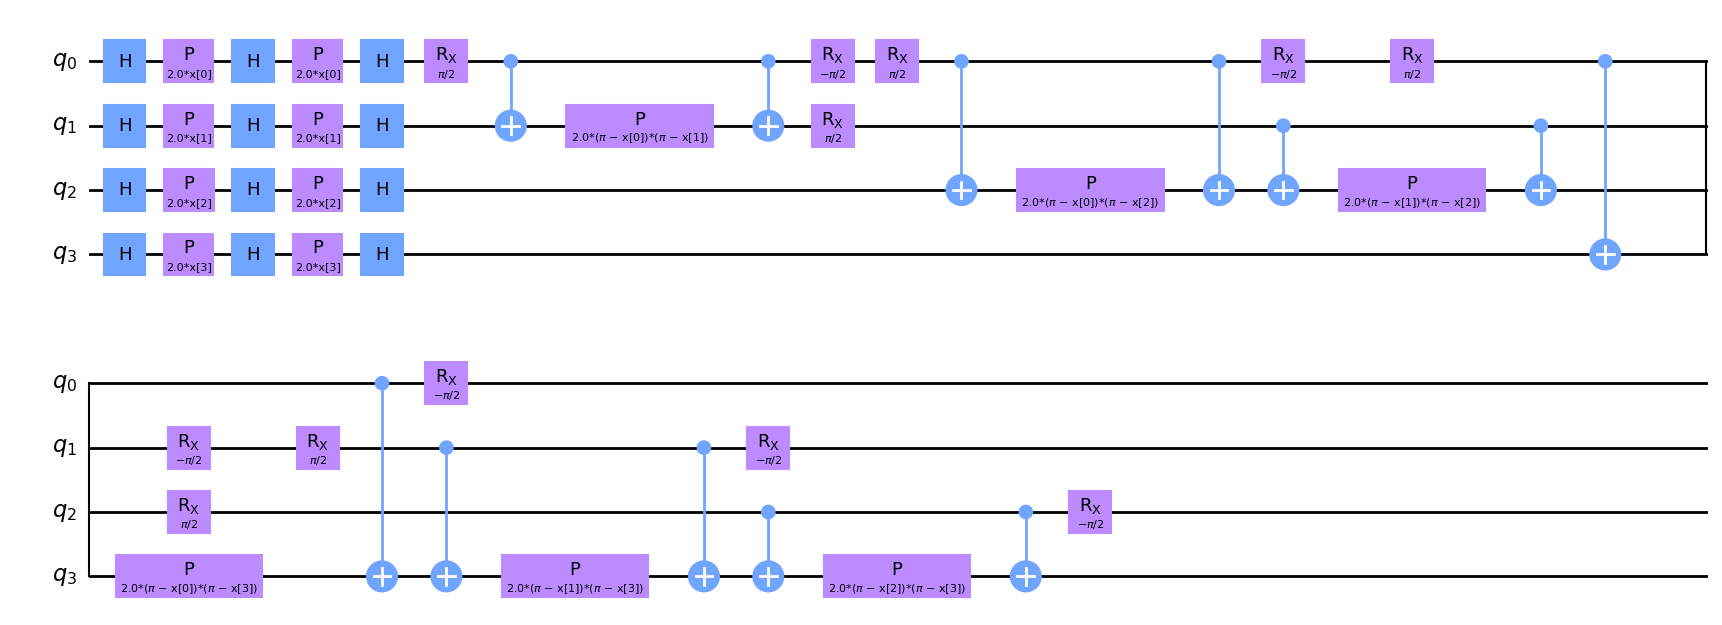

In [10]:
P = PauliFeatureMap(feature_dimension=4, reps=1, paulis = ['Z', 'X', 'ZY'])   # feature_dimension = num_features
P.decompose().draw(output='mpl')

# Quantum ML models 

## Estimator QNN

The EstimatorQNN is a neural network that takes in a parametrized quantum circuit with designated parameters for input data and/or weights, an optional observable(s) and outputs their expectation value(s)

## Sampler QNN

The SamplerQNN is a network based on the samples resulting from measuring a quantum circuit. 
Differently from the estimator qnn does not require a custom observable.However, the SamplerQNN also allows us to specify an interpret function to post-process the samples.
It's important to note that if a custom interpret function is defined, the output_shape cannot be inferred by the network, and needs to be provided explicitly.

## Hybrid QNN

The HybridQNN is a classical neural network in which some classical layer are replaced by qnn.
The implementation in Qiskit uses the `TorchConnector` class. After defining our quantum neural network layer (in this case, a EstimatorQNN), we can embed it into a layer in our torch Module by initializing a torch connector as `TorchConnector(qnn)`.
In order to have an adequate gradient backpropagation in hybrid models, we MUST set the initial parameter `input_gradients` to TRUE during the qnn initialization.

### Testing the models

In [14]:
algorithm_globals.random_seed = 42 #Qiskit random seed
manual_seed(42) #Torch random seed

In [15]:
#Model creation, training and evaluation

hybrid_dim = 3 # number of qubits in the quantum layer of the hybrid model
hidden_dim = 10  # number of hidden layers of the hybrid model
epochs = 10  # number of epochs of the hybrid model

for dataset_name in ("Thin", "Large"):
    for feature_map_name in ("Z", "ZZ", "P"):
        for model_name in ("Estimator", "Sampler", "Hybrid"):
            
            acc = 0
            
            #Choosing the dataset format
            if dataset_name == "Thin":
                X_train = X_Thin_train
                X_test = X_Thin_test
            else:
                X_train = X_Large_train
                X_test = X_Large_test
                
            dims = X_train.shape[1]    # Dimension of the circuit
                
            #Chosing the feature map
            if feature_map_name == "Z":
                feature_map = ZFeatureMap(feature_dimension=dims, reps=1)
            elif feature_map_name == "ZZ":
                feature_map = ZZFeatureMap(feature_dimension=dims, reps=1) 
            else:
                feature_map = PauliFeatureMap(feature_dimension=dims, reps=1, paulis = ['Z', 'X', 'ZY'])
              
            # Start timing
            start = time.time()
            
            # Chosing the model between Estimator, Sampler and Hybrid
            
            if model_name == "Estimator":
                
                observable1 = SparsePauliOp.from_list([("Y" * dims, 1)])  # observable of the estimator QNN
                ansatz = RealAmplitudes(num_qubits=dims)
                qc = QuantumCircuit(dims)
                qc.compose(feature_map, inplace=True)
                qc.compose(ansatz, inplace=True)
                
                # Building the circuit
                Eqnn = EstimatorQNN(
                    circuit=qc,
                    observables=observable1,
                    input_params=feature_map.parameters,
                    weight_params=ansatz.parameters
                )
                
                Eqnn.input_gradients = True  # Used for torch connector
                # The initial weights are in the interval (-0.1, 0.1)
                initial_weights = 0.1 * (2 * algorithm_globals.random.random(Eqnn.num_weights) - 1)
                
                # Building the model
                model = TorchConnector(Eqnn, initial_weights=initial_weights)
                optimizer = LBFGS(model.parameters())
                f_loss = MSELoss()
                model.train() # Starting the train mode
                # Preparing the dataset
                X_ = tensor(X_train).float()
                y_ = tensor(y_train).reshape(-1, 1).float()
                
                # Some optimization algorithms such as LBFGS need to
                # reevaluate the function multiple times, so you have to
                # pass in a closure that allows them to recompute your model.
                # The closure should clear the gradients, compute the loss,
                # and return it.
                def closure():
                    optimizer.zero_grad()  # Initialize/clear gradients
                    loss = f_loss(model(X_), y_)  # Evaluate loss function
                    loss.backward()  # Backward pass
                    return loss
                
                # Training
                optimizer.step(closure)
                
                # Evaluation
                model.eval() # Starting the evaluation mode
                acc = 0
                for x, y_target in zip(X_test, y_test):
                    output = (model(tensor(x))).detach().numpy()
                    res = np.sign(output[0])
                    if res == y_target:
                        acc += 1
                acc = acc/len(y_test)
                
                
            elif model_name == "Sampler":
                
                ansatz = RealAmplitudes(num_qubits=dims, entanglement="linear", reps=1)
                qc = QuantumCircuit(dims)
                qc.compose(feature_map, inplace=True)
                qc.compose(ansatz, inplace=True)
                
                # If we define a custom interpret function ( in the example: parity)
                # we must remember to explicitly provide the desired output shape
                # The function "parity" transforms x into binary and sums the 1s
                # and returns modulo 2 of the sum
                parity = lambda x: "{:b}".format(x).count("1") % 2 
                output_shape = 2  # parity = 0, 1
                
                # Building the circuit
                Sqnn = SamplerQNN(
                    circuit=qc,
                    input_params=feature_map.parameters,
                    weight_params=ansatz.parameters,
                    interpret=parity,
                    output_shape=output_shape,
                )
                initial_weights = 0.1 * (2 * algorithm_globals.random.random(Sqnn.num_weights) - 1)
                
                # Building the model
                model = TorchConnector(Sqnn, initial_weights)
                optimizer = LBFGS(model.parameters())
                f_loss = CrossEntropyLoss()  # The output will be in the [0,1] range so the crossentropy loss can be used
                model.train()  # starting the train mode
                X_ = tensor(X_train)
                y01_ = tensor(y01_train).reshape(-1).long() #This should be in the range (0,1) and should be a 1 dim tensor
                def closure():
                    optimizer.zero_grad(set_to_none=True)  # Initialize gradient
                    loss = f_loss(model(X_), y01_)  # Calculate loss
                    loss.backward()  # Backward pass
                    return loss
                
                # Training
                optimizer.step(closure)
                
                # Evaluation
                model.eval() # Starting the evaluation mode
                acc = 0
                for x, y_target in zip(X_test, y01_test):
                    output = (model(tensor(x))).detach().numpy()
                    res = list(output).index(max(output))
                    if res == y_target:
                        acc += 1
                acc = acc/len(y01_test)
            
            elif model_name == "Hybrid":
                
                # Building a new feature map since the dimension of the quantum
                # layer is different from "dims"
                if feature_map_name == "Z":
                    feature_map = ZFeatureMap(feature_dimension=hybrid_dim, reps=1)
                elif feature_map_name == "ZZ":
                    feature_map = ZZFeatureMap(feature_dimension=hybrid_dim, reps=1) 
                else:
                    feature_map = PauliFeatureMap(feature_dimension=hybrid_dim, reps=1, paulis = ['Z', 'X', 'ZY'])
                    
                ansatz = RealAmplitudes(hybrid_dim, reps=1)
                qc = QuantumCircuit(hybrid_dim)
                qc.compose(feature_map, inplace=True)
                qc.compose(ansatz, inplace=True)
                
                # Building circuit. It's gonna be an estimator QNN
                Hqnn = EstimatorQNN(
                    circuit=qc,
                    input_params=feature_map.parameters,
                    weight_params=ansatz.parameters,
                    input_gradients=True,
                )
                
                # Defining the hybrid QNN
                class Net(Module):
                    def __init__(self, Hqnn):
                        super().__init__()
                        self.fc1 = Linear(dims, hidden_dim)
                        self.fc2 = Linear(hidden_dim, hybrid_dim)  # input to QNN
                        self.Hqnn = TorchConnector(Hqnn)  # Apply torch connector
                        self.fc3 = Linear(1, 1)  # 1-dimensional output from QNN
                        self.sig = Sigmoid()  # Sigmoid function

                    def forward(self, x):
                        x = F.relu(self.fc1(x))
                        x = self.fc2(x)
                        x = self.Hqnn(x)  # apply QNN
                        x = self.fc3(x)
                        x = self.sig(x)
                        return cat((x, 1 - x), -1)
                
                # Building the model
                model = Net(Hqnn)
                optimizer = optim.Adam(model.parameters(), lr=0.001)
                loss_func = NLLLoss()
                model.train()  # Set the model to training mode
                
                # Training the model on different epochs
                for epoch in range(epochs):
                    for x_, y_ in zip(X_train, y01_train):
                        optimizer.zero_grad(set_to_none=True)  # Initialize gradient
                        output = model(tensor(x_).float())  # Forward pass
                        loss = loss_func(output, tensor(y_))  # Calculate loss
                        loss.backward()  # Backward pass
                        optimizer.step()  # Optimize weights
                        
                # Evaluation
                model.eval()  # set model to evaluation mode
                with no_grad():
                    acc = 0
                    for x, y_target in zip(X_test, y01_test):
                        output = (model(tensor(x).float())).detach().numpy()
                        res = list(output).index(max(output))
                        if res == y_target:
                            acc += 1
                    acc = acc/len(y01_test)
            
            
            #End timing
            end = time.time()
            elapsed = end-start
            
            
            print(f"Time spent for {model_name} QNN with feature map {feature_map_name} and dataset {dataset_name} : {elapsed}")
            print(f"The accuracy is : {acc}")
            print("- - - - -")
        
            

Time spent for Estimator QNN with feature map Z and dataset Thin : 383.93181443214417
The accuracy is : 0.7666666666666667
- - - - -
Time spent for Sampler QNN with feature map Z and dataset Thin : 108.80613589286804
The accuracy is : 0.75
- - - - -
Time spent for Hybrid QNN with feature map Z and dataset Thin : 54.8503999710083
The accuracy is : 0.85
- - - - -
Time spent for Estimator QNN with feature map ZZ and dataset Thin : 691.2945590019226
The accuracy is : 0.6
- - - - -
Time spent for Sampler QNN with feature map ZZ and dataset Thin : 179.95403575897217
The accuracy is : 0.6166666666666667
- - - - -
Time spent for Hybrid QNN with feature map ZZ and dataset Thin : 103.6485641002655
The accuracy is : 0.6
- - - - -
Time spent for Estimator QNN with feature map P and dataset Thin : 1024.741391658783
The accuracy is : 0.5
- - - - -
Time spent for Sampler QNN with feature map P and dataset Thin : 247.60093784332275
The accuracy is : 0.48333333333333334
- - - - -
Time spent for Hybrid 

# Visualizing the results

- - - - -
Accuracy: 
- - - - -


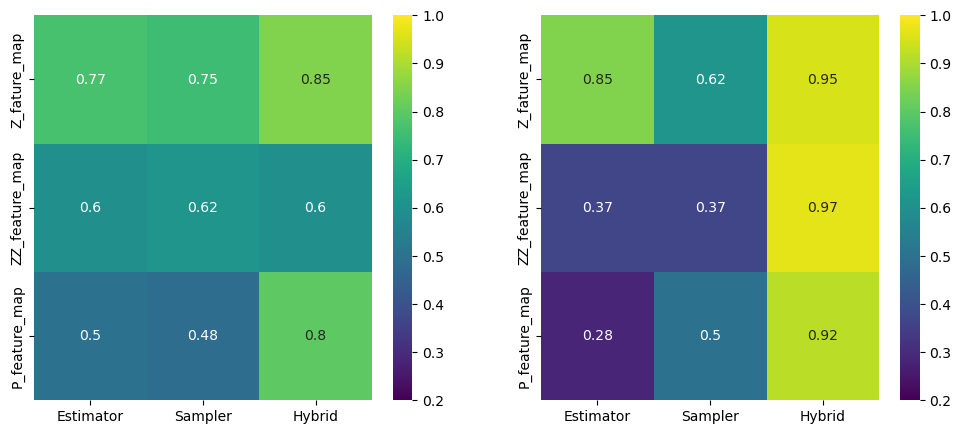

- - - - - - - - - - - - - - - - - - - - -
Time (seconds) for training + evaluation: 
- - - - - - - - - - - - - - - - - - - - - 


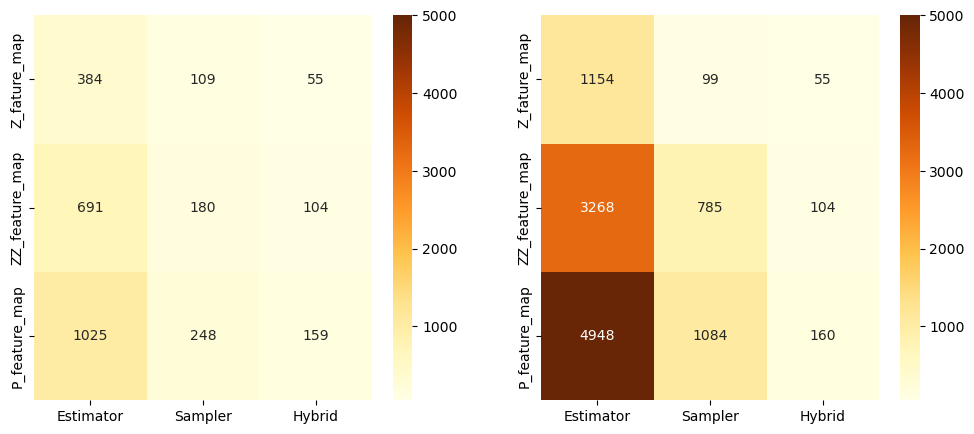

In [31]:
results_thin = [[0.7666, 0.75, 0.85], [0.6, 0.6166, 0.6], [0.5, 0.4833, 0.8]]
results_large = [[0.85, 0.6166, 0.95], [0.3666, 0.3666, 0.9666], [0.2833, 0.5, 0.9166]]

time_thin = [[383.93181443214417, 108.80613589286804, 54.8503999710083], [691.2945590019226, 179.95403575897217, 103.6485641002655], [1024.741391658783, 247.60093784332275, 159.3301751613617]]
time_large = [[1153.7282207012177, 99.37096500396729, 54.77226257324219], [3268.1521096229553, 784.9025185108185, 104.01314210891724], [4947.994287014008, 1084.4362971782684, 159.8410518169403]]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

sns.heatmap(results_thin, xticklabels = ["Estimator", "Sampler", "Hybrid"], yticklabels = ["Z_fature_map", "ZZ_feature_map", "P_feature_map"], annot=True, cmap = "viridis", ax=ax1, vmin = 0.2, vmax = 1)
sns.heatmap(results_large, xticklabels = ["Estimator", "Sampler", "Hybrid"], yticklabels = ["Z_fature_map", "ZZ_feature_map", "P_feature_map"], annot=True, cmap = "viridis", ax=ax2, vmin = 0.2, vmax = 1)

print("- - - - -")
print("Accuracy: ")
print("- - - - -")

plt.show()

print("- - - - - - - - - - - - - - - - - - - - -")
print("Time (seconds) for training + evaluation: ")
print("- - - - - - - - - - - - - - - - - - - - - ")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

sns.heatmap(time_thin, xticklabels = ["Estimator", "Sampler", "Hybrid"], yticklabels = ["Z_fature_map", "ZZ_feature_map", "P_feature_map"], cmap = "YlOrBr", annot=True, fmt = ".0f", ax=ax1, vmin = 50, vmax = 5000)
sns.heatmap(time_large, xticklabels = ["Estimator", "Sampler", "Hybrid"], yticklabels = ["Z_fature_map", "ZZ_feature_map", "P_feature_map"], cmap = "YlOrBr", annot=True, fmt = ".0f", ax=ax2, vmin = 50, vmax = 5000)

plt.show()

### We can try to run the Hybrid QNN again to test the results on more iterations and more data, we can also see that the best dataset format for the hybrid was the "Large" one, so we continue using that

In [5]:
# Recreating the dataset
X = df.drop('fraud', axis=1)
y = df['fraud']

# undesapling the dataset to have only 100 fraud and 100 non-fraud samples
sampling_strategy = {0: 1000, 1: 1000}

# Undersample the majority class
undersample = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
X_resampled, y_resampled = undersample.fit_resample(X, y)

#Train test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=0)
print(X_train.shape, X_test.shape)

(1400, 4) (600, 4)


In [6]:
# X_Large_train
cat0 = []
cat1 = []
cat2 = []
cat3 = []

category = list(X_train['category'])
for i in range(X_train.shape[0]):
    # Convert to binary and remove the '0b' prefix
    binstr = bin(category[i])[2:]
    while len(binstr)<4:
        binstr = '0'+binstr
    #creating the classes for the 0th, 1st, 2nd and 3rd bit of the binary encoding 
    cat0.append(binstr[3])
    cat1.append(binstr[2])
    cat2.append(binstr[1])
    cat3.append(binstr[0])

d = {'age': list(X_train['age']), 'gender': list(X_train['gender']),'cat3': cat3, 'cat2': cat2, 'cat1': cat1, 'cat0': cat0, 'amount': list(X_train['amount'])}

X_Large_train = pd.DataFrame(data=d)
X_Large_train = MinMaxScaler().fit_transform(X_Large_train)



#X_Large_test
cat0 = []
cat1 = []
cat2 = []
cat3 = []

category = list(X_test['category'])
for i in range(X_test.shape[0]):
    # Convert to binary and remove the '0b' prefix
    binstr = bin(category[i])[2:]
    while len(binstr)<4:
        binstr = '0'+binstr
    #creating the classes for the 0th, 1st, 2nd and 3rd bit of the binary encoding 
    cat0.append(binstr[3])
    cat1.append(binstr[2])
    cat2.append(binstr[1])
    cat3.append(binstr[0])

d = {'age': list(X_test['age']), 'gender': list(X_test['gender']),'cat3': cat3, 'cat2': cat2, 'cat1': cat1, 'cat0': cat0, 'amount': list(X_test['amount'])}

X_Large_test = pd.DataFrame(data=d)
X_Large_test = MinMaxScaler().fit_transform(X_Large_test)

In [7]:
# Transforming the y dataframes in to ndarrays

# y01 represent the arrays of values between 0 and 1 (used for the sampler and the hybrid)
y01_train = y_train.to_numpy()
y01_test = y_test.to_numpy()

# these y are in the range (-1, 1) and are used for the estimator
y_train = (y01_train * 2) - 1
y_test = (y01_test * 2) - 1

## Training and testing

- - - - -
Time spent for Hybrid QNN with feature map Z and dataset Large : 2040.5503914356232
The accuracy is : 0.9633333333333334
- - - - -
- - - - -
Time spent for Hybrid QNN with feature map ZZ and dataset Large : 4192.692080497742
The accuracy is : 0.9633333333333334
- - - - -
- - - - -
Time spent for Hybrid QNN with feature map P and dataset Large : 6661.815709114075
The accuracy is : 0.9633333333333334
- - - - -


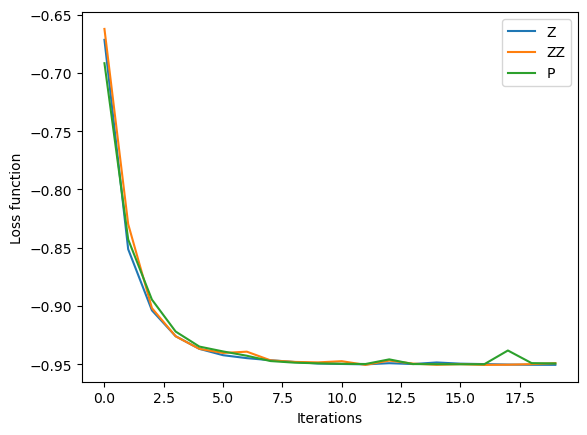

In [26]:
hybrid_dim = 4
hidden_dim = 32
epochs = 20
dims = 7

# The dataset will be the large one
X_train = X_Large_train
X_test = X_Large_test

# Defining the hybrid QNN
class Net(Module):
    def __init__(self, Hqnn):
        super().__init__()
        self.fc1 = Linear(dims, hidden_dim)
        self.fc2 = Linear(hidden_dim, hybrid_dim)  # input to QNN
        self.Hqnn = TorchConnector(Hqnn)  # Apply torch connector
        self.fc3 = Linear(1, 1)  # 1-dimensional output from QNN
        self.sig = Sigmoid()  # Sigmoid function

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.Hqnn(x)  # apply QNN
        x = self.fc3(x)
        x = self.sig(x)
        return cat((x, 1 - x), -1)
    
Loss_Z = []
Loss_ZZ = []
Loss_P = []

# Chosing the feature map
for feature_map_name in ("Z", "ZZ", "P"):
    
    acc = 0
    
    # Start timing
    start = time.time()
    
    if feature_map_name == "Z":
        feature_map = ZFeatureMap(feature_dimension=hybrid_dim, reps=1)
    elif feature_map_name == "ZZ":
        feature_map = ZZFeatureMap(feature_dimension=hybrid_dim, reps=1) 
    else:
        feature_map = PauliFeatureMap(feature_dimension=hybrid_dim, reps=1, paulis = ['Z', 'X', 'ZY'])

    ansatz = RealAmplitudes(hybrid_dim, reps=1)
    qc = QuantumCircuit(hybrid_dim)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)

    # Building circuit. It's gonna be an estimator QNN
    Hqnn = EstimatorQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True,
    )

    # Building the model
    model = Net(Hqnn)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_func = NLLLoss()
    model.train()  # Set the model to training mode

    # Training the model and saving the loss
    for epoch in range(epochs):
        total_loss = 0
        for x_, y_ in zip(X_train, y01_train):
            optimizer.zero_grad(set_to_none=True)  # Initialize gradient
            output = model(tensor(x_).float())  # Forward pass
            loss = loss_func(output, tensor(y_))  # Calculate loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize weights
            total_loss += loss.item()  # Store loss
        
        total_loss /= len(X_train)
        
        if feature_map_name == "Z":
            Loss_Z.append(total_loss)
        elif feature_map_name == "ZZ":
            Loss_ZZ.append(total_loss)
        else:
            Loss_P.append(total_loss)

        
    # Evaluation
    model.eval()  # set model to evaluation mode
    with no_grad():
        acc = 0
        for x, y_target in zip(X_test, y01_test):
            output = (model(tensor(x).float())).detach().numpy()
            res = list(output).index(max(output))
            if res == y_target:
                acc += 1
        acc = acc/len(y01_test)        
    
    #End timing
    end = time.time()
    elapsed = end-start

    print("- - - - -")
    print(f"Time spent for Hybrid QNN with feature map {feature_map_name} and dataset Large : {elapsed}")
    print(f"The accuracy is : {acc}")
    print("- - - - -")
    
plt.xlabel("Iterations")
plt.ylabel("Loss function")
plt.plot(range(len(Loss_Z)), Loss_Z, label='Z')
plt.plot(range(len(Loss_ZZ)), Loss_ZZ, label='ZZ')
plt.plot(range(len(Loss_P)), Loss_P, label='P')
plt.legend()
plt.show()


All the models seem to converge to the same result and all them have high accuracy. 

The results must be compared to results obrained by purely classical models and with noisy models.

## Pure classical model

- - - - -
Time spent for Classical QNN number 0 with dataset Large : 27.98853611946106
The accuracy is : 0.935
- - - - -
- - - - -
Time spent for Classical QNN number 1 with dataset Large : 25.1418879032135
The accuracy is : 0.935
- - - - -
- - - - -
Time spent for Classical QNN number 2 with dataset Large : 25.58496594429016
The accuracy is : 0.935
- - - - -


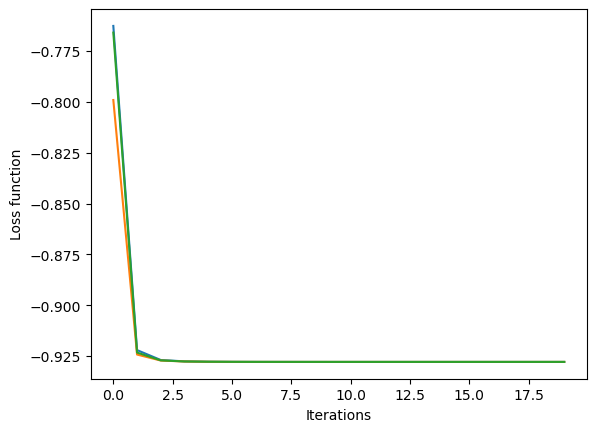

In [8]:
hybrid_dim = 4
hidden_dim = 32
epochs = 20
dims = 7

# The dataset will be the large one
X_train = X_Large_train
X_test = X_Large_test

Loss_classic_lists = []  # Defining the list of lists of losses

# Defining the classical NN
class Net(Module):
    def __init__(self):
        super().__init__()
        self.fc1 = Linear(dims, hidden_dim)
        self.fc2 = Linear(hidden_dim, hybrid_dim)
        self.fc3 = Linear(hybrid_dim, 1)  # susbtitute of the quantum layer
        self.sig = Sigmoid()  # Sigmoid function

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.sig(x)
        return cat((x, 1 - x), -1)

# Starting the iterations of the training/evaluation to reduce statistical errors
for i in range(3):
    
    Loss_classic = []
    
    # Start timing
    start = time.time()

    # Building the model
    model = Net()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_func = NLLLoss()
    model.train()  # Set the model to training mode

    # Training the model and saving the loss
    for epoch in range(epochs):
        total_loss = 0
        for x_, y_ in zip(X_train, y01_train):
            optimizer.zero_grad(set_to_none=True)  # Initialize gradient
            output = model(tensor(x_).float())  # Forward pass
            loss = loss_func(output, tensor(y_))  # Calculate loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize weights
            total_loss += loss.item()  # Store loss

        total_loss /= len(X_train)
        Loss_classic.append(total_loss)
        
    # Append the list of losses
    Loss_classic_lists.append(Loss_classic)

    # Evaluation
    model.eval()  # set model to evaluation mode
    with no_grad():
        acc = 0
        for x, y_target in zip(X_test, y01_test):
            output = (model(tensor(x).float())).detach().numpy()
            res = list(output).index(max(output))
            if res == y_target:
                acc += 1
        acc = acc/len(y01_test)        

    #End timing
    end = time.time()
    elapsed = end-start

    print("- - - - -")
    print(f"Time spent for Classical QNN number {i} with dataset Large : {elapsed}")
    print(f"The accuracy is : {acc}")
    print("- - - - -")

plt.xlabel("Iterations")
plt.ylabel("Loss function")
plt.plot(range(len(Loss_classic_lists[0])), Loss_classic_lists[0], label='Run_1')
plt.plot(range(len(Loss_classic_lists[1])), Loss_classic_lists[1], label='Run_2')
plt.plot(range(len(Loss_classic_lists[2])), Loss_classic_lists[2], label='Run_3')
plt.show()



The models seem to converge to the same results after few iterations, suggesting that there's no need for many iterations in the classical model

The slight difference in accuracy with respect to the hybrid model can be a sign of slight overfitting.

# Noisy model

Now we can try to run the noisy model and see the difference with the noise-free implementation

In [13]:
# Defining the backend

device_backend = FakeVigo()
sim_vigo = AerSimulator.from_backend(device_backend)

sim_vigo.shots = 1000
sim_vigo.optimization_level = 3

Back_est = BackendEstimator(backend=sim_vigo)

Since the noisy model takes a lot of time, it will be tested only on the smaller version of the "large" dataset.

NOTE: The next three cells below are just to recreate the smaller initial dataset

In [23]:
X = df.drop('fraud', axis=1)
y = df['fraud']

# undesapling the dataset to have only 100 fraud and 100 non-fraud samples
sampling_strategy = {0: 100, 1: 100}

# Undersample the majority class
undersample = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
X_resampled, y_resampled = undersample.fit_resample(X, y)

#Train test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=0)
print(X_train.shape, X_test.shape)

(140, 4) (60, 4)


In [24]:
# Redefining the "Large" dataset

# X_Large_train
cat0 = []
cat1 = []
cat2 = []
cat3 = []

category = list(X_train['category'])
for i in range(X_train.shape[0]):
    # Convert to binary and remove the '0b' prefix
    binstr = bin(category[i])[2:]
    while len(binstr)<4:
        binstr = '0'+binstr
    #creating the classes for the 0th, 1st, 2nd and 3rd bit of the binary encoding 
    cat0.append(binstr[3])
    cat1.append(binstr[2])
    cat2.append(binstr[1])
    cat3.append(binstr[0])

d = {'age': list(X_train['age']), 'gender': list(X_train['gender']),'cat3': cat3, 'cat2': cat2, 'cat1': cat1, 'cat0': cat0, 'amount': list(X_train['amount'])}

X_Large_train = pd.DataFrame(data=d)
X_Large_train = MinMaxScaler().fit_transform(X_Large_train)



#X_Large_test
cat0 = []
cat1 = []
cat2 = []
cat3 = []

category = list(X_test['category'])
for i in range(X_test.shape[0]):
    # Convert to binary and remove the '0b' prefix
    binstr = bin(category[i])[2:]
    while len(binstr)<4:
        binstr = '0'+binstr
    #creating the classes for the 0th, 1st, 2nd and 3rd bit of the binary encoding 
    cat0.append(binstr[3])
    cat1.append(binstr[2])
    cat2.append(binstr[1])
    cat3.append(binstr[0])

d = {'age': list(X_test['age']), 'gender': list(X_test['gender']),'cat3': cat3, 'cat2': cat2, 'cat1': cat1, 'cat0': cat0, 'amount': list(X_test['amount'])}

X_Large_test = pd.DataFrame(data=d)
X_Large_test = MinMaxScaler().fit_transform(X_Large_test)


In [25]:
# Transforming the y dataframes in to ndarrays

# y01 represent the arrays of values between 0 and 1 (used for the sampler and the hybrid)
y01_train = y_train.to_numpy()
y01_test = y_test.to_numpy()

# these y are in the range (-1, 1) and are used for the estimator
y_train = (y01_train * 2) - 1
y_test = (y01_test * 2) - 1

## Starting the iterations on the noisy model

- - - - -
Time spent for Noisy QNN with dataset Large : 1102.8102567195892
The accuracy is : 0.9333333333333333
- - - - -


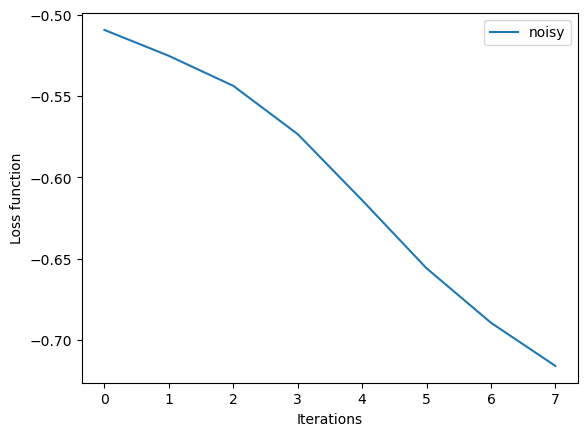

In [26]:
hybrid_dim = 4
hidden_dim = 32
epochs = 8   # We reduce the epochs to reduce the computation time
dims = 7

# Using the large dataset
X_train = X_Large_train
X_test = X_Large_test

Loss_noisy = []  # List of loss functions

# Creating the quantum circuit with Z feature map
feature_map = ZFeatureMap(feature_dimension=hybrid_dim, reps=1)
ansatz = RealAmplitudes(hybrid_dim, reps=1)
qc = QuantumCircuit(hybrid_dim)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)

# Building the noisy estimator circuit
Nqnn = EstimatorQNN(
    estimator=Back_est, 
    circuit=qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    input_gradients=True,
)

# Defining the noisy QNN
class Net(Module):
    def __init__(self, Nqnn):
        super().__init__()
        self.fc1 = Linear(dims, hidden_dim)
        self.fc2 = Linear(hidden_dim, hybrid_dim)  # input to QNN
        self.Nqnn = TorchConnector(Nqnn)  # Apply torch connector
        self.fc3 = Linear(1, 1)  # 1-dimensional output from QNN
        self.sig = Sigmoid()  # Sigmoid function

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.Nqnn(x)  # apply QNN
        x = self.fc3(x)
        x = self.sig(x)
        return cat((x, 1 - x), -1)
    
# Start timing
start = time.time()

# Building the model
model = Net(Nqnn)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = NLLLoss()
model.train()  # Set the model to training mode

# Training the model and saving the loss
for epoch in range(epochs):
    total_loss = 0
    for x_, y_ in zip(X_train, y01_train):
        optimizer.zero_grad(set_to_none=True)  # Initialize gradient
        output = model(tensor(x_).float())  # Forward pass
        loss = loss_func(output, tensor(y_))  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize weights
        total_loss += loss.item()  # Store loss

    total_loss /= len(X_train)
    Loss_noisy.append(total_loss)

# Evaluation
model.eval()  # set model to evaluation mode
with no_grad():
    acc = 0
    for x, y_target in zip(X_test, y01_test):
        output = (model(tensor(x).float())).detach().numpy()
        res = list(output).index(max(output))
        if res == y_target:
            acc += 1
    acc = acc/len(y01_test)        

#End timing
end = time.time()
elapsed = end-start

print("- - - - -")
print(f"Time spent for Noisy QNN with dataset Large : {elapsed}")
print(f"The accuracy is : {acc}")
print("- - - - -")

plt.xlabel("Iterations")
plt.ylabel("Loss function")
plt.plot(range(len(Loss_noisy)), Loss_noisy, label='noisy')
plt.legend()
plt.show()


The model seem to perfom a similar way to the noise-free one. 

Since the loss function seem to be still decreasing it suggests that with more iterations and more data the model can still improve

## Conclusion:

if we consider the original dataset (thin), then all the model have comparable results, with the hybrid model performing a bit better than the others. 
For the feature map it seems that the simpler map (Z_feature map) works better than the more complex ones.

If we consider the modified dataset (large) the results change drastically.
The hybrid model is the clear winner and outperforms the previous results obtaining almost perfect results.
This is also obtained without the need for higher computational time.
On the other hand, all the other models seem to be become practically useless, since their performance is similar (or even lower) than that of a random classifier.
There is also a weird correlation between execution time and accuracy, since the runs with the worst results are also the ones with the longer execution time.

In the second part of the experiment the complexity of the hybrid model was increased:

The hidden layer dimension was set to 32, the dimension off the QC was increased to 4 and the epochs used in training were doubled. 
The "large" dataset was also increased to contain 1000 expemple of fraudolent transactions and 1000 normal transactions.
This made the training and evaluation of the model a lot more expensive as a result.

The accuracies of this second run were also excellent.
All the models achieved near perfect results and managed to outperform their less complex couterparts.

A big part of this result can be explained by the use of a classical neural network layer, but the slight difference in accuracy suggest that the classical neural network might be overfitting a bit.

The results were also compared with a noisy model but no significant difference can be noticed.


This experiment shows the potential of hybrid quantum / classical neural networks, and suggests the use of classical layers before a quantum layer to overcome the problems associated to having too many qubits (e.g. Barren plateaus). 
Another important thing to note was the importance of preprocessing data, since the large dataset was clearly better suited for the hybrid model.
This shows that binary encoding for categorical variables can be best choice for this kind of models.